In [15]:
from torch_geometric.datasets import Amazon
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
from torch_geometric.utils.convert import to_networkx
from torch_geometric.utils import homophily
import networkx as nx
from tqdm.notebook import tqdm
from utils import *
import pandas as pd
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
from functools import partial
import pickle as pkl
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
dataset = Amazon('data/', 'Computers', pre_transform=RandomNodeSplit(split='train_rest', num_val=1000, num_test=10000))
data = dataset[0]
test_subgraph = data.subgraph(data.test_mask)
test_subgraph

Data(x=[12000, 767], edge_index=[2, 375216], y=[12000], train_mask=[12000], val_mask=[12000], test_mask=[12000])

In [17]:
data.train_mask.sum()

tensor(752)

In [18]:
homophily(data.edge_index, data.y, method='node')

0.7853084206581116

In [19]:
G = to_networkx(test_subgraph).to_undirected()

In [20]:
G

In [21]:
def get_nbhd_weights(G, node, k, geom=True):
    # Get dict containing nodes -> shortest path to node (i.e. depth).
    node_depth_map = pd.Series(nx.single_source_shortest_path_length(G, node, cutoff=k), name='distance')
    node_depth_map.index.name = 'node_id'
    node_depth_map = node_depth_map.drop(node) # Remove the node itself from list.
    node_depth_map = node_depth_map.reset_index()

    if geom:
        node_depth_map['weight'] = (0.5)**(node_depth_map['distance'] - 1)  # Weight =
    else:
        node_depth_map['weight'] = 1
    return node_depth_map

In [22]:
exp_path = 'experiments/01-11-2022_19-13-44_Computers' #- SAGE MEAN WORKING
# exp_path = 'experiments/01-11-2022_19-19-38_Computers' ## 0.765 accuracy
# exp_path = 'experiments/01-11-2022_19-51-57_Computers_SHADOW'  # 0.816 accuracy
preds_path = os.path.join(exp_path, 'preds.pkl')
with open(preds_path, 'rb') as f:
    preds = pkl.load(f)
# preds = preds[lcc_nodes]
# test_x = test_subgraph.x[lcc_nodes].numpy()
# test_y = test_subgraph.y[lcc_nodes].numpy()
preds = pd.DataFrame(preds)
test_x = pd.DataFrame(data.x[data.test_mask].numpy())
test_y = pd.DataFrame(data.y[data.test_mask].numpy())

print(len(preds))
print(len(test_x))
print(len(test_y))

12000
12000
12000


In [23]:
probs = test_y.value_counts() / len(test_y)
probs.name = 'Proportion'
probs.index.name = 'Class'
probs
sum(probs**2)

0.20821679166666668

In [114]:
preds

,0,1,2,3,4,5,6,7,8,9
0,0.001019,0.012192,0.000242,0.001248,0.981258,0.001018,0.000460,0.000040,0.002378,0.000144
1,0.000152,0.000945,0.000019,0.001719,0.994370,0.000599,0.000108,0.000005,0.002061,0.000022
2,0.002745,0.170167,0.000867,0.007826,0.079542,0.006717,0.051183,0.000726,0.667538,0.012690
3,0.001630,0.042534,0.000193,0.001450,0.006835,0.000807,0.173975,0.001544,0.755072,0.015959
4,0.006758,0.340329,0.004453,0.012377,0.357808,0.008083,0.029956,0.003525,0.227383,0.009327
...,...,...,...,...,...,...,...,...,...,...
11995,0.019219,0.006341,0.787021,0.001750,0.003921,0.002764,0.001703,0.175277,0.000492,0.001510
11996,0.000001,0.994706,0.000097,0.000013,0.000352,0.000004,0.000192,0.000077,0.004519,0.000038
11997,0.000127,0.008200,0.000011,0.000312,0.001061,0.000095,0.105142,0.000144,0.880699,0.004209
11998,0.000767,0.012805,0.000124,0.000883,0.979565,0.000127,0.000166,0.000008,0.005523,0.000033


In [115]:
G.number_of_nodes()

12000

In [116]:
## Compute the NAPS prediction set for each node in advance.
alpha = 0.1
cutoff = 50
quantiles_nb = []
def calibrate_nbhd(node):
    nbs = get_nbhd_weights(G, node, k=2, geom=False)
    nb_ids = nbs['node_id'].values
    if cutoff <= len(nb_ids):
        quantile = calibrate(preds.loc[nb_ids].values,
                             np.squeeze(test_y.loc[nb_ids].values), alpha)
        return {node: quantile[0]}
quantiles_nb = process_map(calibrate_nbhd, list(G.nodes), max_workers=12)

/tmp/ipykernel_283066/2080877440.py:12: TqdmWarning: Iterable length 12000 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(calibrate_nbhd, list(G.nodes), max_workers=12)


  0%|          | 0/12000 [00:00<?, ?it/s]

In [117]:
nz = [p for p in quantiles_nb if p is not None]
res = {}
for p in nz:
    res.update(p)
nbhd_quantiles = pd.Series(res, name='quantile')
nbhd_quantiles
lcc_nodes = nbhd_quantiles.index.values
sets_nb = predict(preds.loc[lcc_nodes].values, nbhd_quantiles.values[:, None])
sets_nb = pd.Series(sets_nb, index=lcc_nodes, name='set')

In [118]:
len(lcc_nodes)

11033

In [119]:
n_trials = 100
n_eval = 1000

In [120]:
nb_stats = []
full_stats = []
# with mp.Pool(12) as p:
for k in tqdm(range(n_trials)):
    ## Sample the prediction nodes.
    pred_nodes = np.random.choice(lcc_nodes, size=n_eval, replace=False)
    # Neighbourhood calibration is pre-computed, so just get prediction sets for them.
    nb_stats.append(evaluate_predictions(sets_nb[pred_nodes].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values)
                                         ))
    # Full calibration
    quantile = calibrate(preds[~preds.index.isin(pred_nodes)].values,
                         np.squeeze(test_y[~test_y.index.isin(pred_nodes)].values), alpha)
    sets_full = predict(preds.loc[pred_nodes].values, quantile)
    full_stats.append(evaluate_predictions(sets_full,
                                           test_x.loc[pred_nodes].values,
                                           np.squeeze(test_y.loc[pred_nodes].values)))


  0%|          | 0/100 [00:00<?, ?it/s]

,coverage,set_size,cc_set_size
count,100.000000,100.000000,100.000000
mean,0.901270,1.464920,1.547736
std,0.009427,0.029331,0.027972
min,0.879000,1.376000,1.461017
25%,0.896000,1.448000,1.533443
50%,0.901000,1.464500,1.549281
75%,0.907250,1.479250,1.562881
max,0.929000,1.562000,1.624722


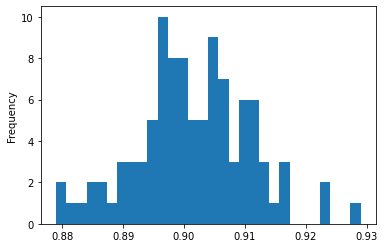

In [121]:
nb_df = pd.DataFrame(nb_stats, columns=['coverage', 'set_size', 'cc_set_size'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size
count,100.000000,100.000000,100.000000
mean,0.902210,1.498850,1.576302
std,0.010943,0.032529,0.031523
min,0.873000,1.431000,1.500552
25%,0.895000,1.473000,1.555832
50%,0.903000,1.498000,1.574893
75%,0.909000,1.522250,1.600833
max,0.926000,1.601000,1.672887


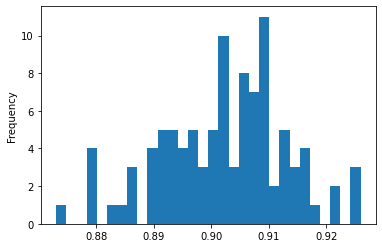

In [122]:
full_df = pd.DataFrame(full_stats, columns=['coverage', 'set_size', 'cc_set_size'])
full_df['coverage'].plot(kind='hist', bins=30)
full_df.describe()